In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
import emcee
import corner
from batman._quadratic_ld import _quadratic_ld as qld

## general functions

In [2]:
def inv_var_weight_avg(x, ex):
    # compute inverse variance weighted average and error
    w = 1./(ex**2) # weights
    x_wav = np.nansum(w * x, axis=0) / np.nansum(w, axis=0)
    σ_wav = 1./np.sqrt(np.nansum(w, axis=0))
    return x_wav, σ_wav


def impact_parameter(t0, t, dx, uy):
    dt = t-t0
    # return the impact parameter
    return np.hypot(dx,uy*dt)


def make_flux(mags, mag_errors, baseline_mag):
    fluxes = 10**(0.4*(baseline_mag- mags))
    flux_errors = fluxes * (10**((2*mag_errors)/5) - 1)
    return fluxes, flux_errors

## mcmc functions

In [3]:
def priors(x):
    if any((x<0)|(x>1)):
        return -np.inf
    else:
        return 0.0


def map01(val, lower, upper):
    return (val * (upper-lower)) + lower

def mapXs(x):
    _x = x.copy()
    if len(_x.shape)==1:
        _x = _x[np.newaxis,:]
    _x[:,0] = t0_est + map01(_x[:,0], -10.0, 10.0) # t0
    _x[:,1] = map01(_x[:,1], 0.0, 1.0) # minimum impact parameter
    _x[:,2] = map01(_x[:,2], 0.0, 0.1) # relative motion
    _x[:,3] = map01(_x[:,3], 0.0, 10.0) # radius of occulter
    # parsec model says giant mass is 0.5->2.2 Msun depending on age (10Gyr->1Gyr)
    # also says logg is approx 0.25->0.75
    # Inside these bounds Neilson and Lester 2013 gives K band linear limb darkening
    # parameter of 0.95->1.15 for high mass -> low mass
    if len(x.shape)==1:
        return _x[0,:]
    return _x


def lnprob(x,t,f,ef):
    """The log-likelihood function."""
    prior = priors(x) # all x between 0 and 1
    if prior<0:
        return prior
    _x = mapXs(x)

    # impact parameters
    b = impact_parameter(_x[0], t, _x[1], _x[2])
    # generate lightcurve
    _f = qld(b, _x[3], 1.05, 0., 1)

    # calc likelihood
    residual = ((f-_f)/ef)**2
    _lnprob = -(np.sum(residual)/2) + prior

    return _lnprob

## load and format data

In [27]:
# Load I data
I = np.genfromtxt('data/OGLE.I.dat', dtype=['f8','f4','f4'], names=['tobs','mag','emag'])
imags = I["mag"]
eimags = I["emag"]
imjdobs = I["tobs"]+50000.

# Load V data
V = np.genfromtxt('data/OGLE.V.dat', dtype=['f8','f4','f4'], names=['tobs','mag','emag'])
vmags = V["mag"]
evmags = V["emag"]
vmjdobs = V["tobs"]+50000.

# Load Ks data
Ks = getdata("data/virac2_data.fits", -1, view=np.recarray)
Ks = Ks[(Ks["tileloc"]!=0) & (Ks["filter"].astype("U2")=="Ks")]
kmags = Ks["hfad_mag"]
ekmags = Ks["hfad_emag"]
kmjdobs = Ks["mjdobs"]

# estimated baseline mag
t0_est = int(imjdobs[np.argmax(imags)])
m0_i_est, em0_i_est = inv_var_weight_avg(imags[np.abs(imjdobs-t0_est)>365],
                                     eimags[np.abs(imjdobs-t0_est)>365])
m0_v_est, em0_v_est = inv_var_weight_avg(vmags[np.abs(vmjdobs-t0_est)>365],
                                         evmags[np.abs(vmjdobs-t0_est)>365])
m0_k_est, em0_k_est = inv_var_weight_avg(kmags[np.abs(kmjdobs-t0_est)>365],
                                         ekmags[np.abs(kmjdobs-t0_est)>365])

# fluxes, errors
iflux, iflux_error = make_flux(imags, eimags, m0_i_est)
vflux, vflux_error = make_flux(vmags, evmags, m0_v_est)
kflux, kflux_error = make_flux(kmags, ekmags, m0_k_est)

# mjdobs, fluxes, flux errors to use for fitting
fit_mjdobs = imjdobs[np.abs(imjdobs-t0_est)<365]
fit_fluxes = iflux[np.abs(imjdobs-t0_est)<365]
fit_flux_errors = iflux_error[np.abs(imjdobs-t0_est)<365]

In [5]:
ndim, nwalkers = 4, 2048
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
nSteps = 512

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[fit_mjdobs,fit_fluxes,fit_flux_errors])
pos, prob, state = sampler.run_mcmc(p0,nSteps)

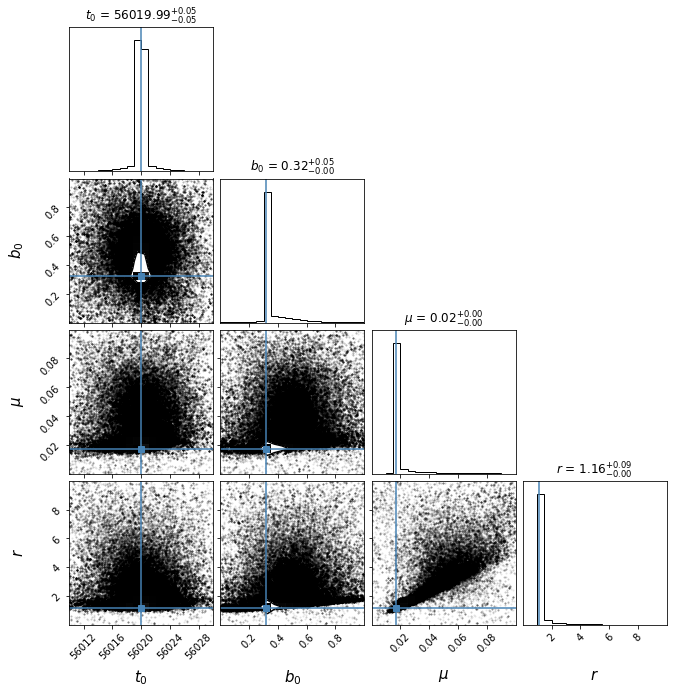

In [20]:
samples = sampler.chain.reshape((-1, ndim))
mapped = mapXs(samples)
bestX = pos[np.argsort(prob)[-1],:]
fig = corner.corner(mapped,
                    labels=[r"$t_{0}$",
                            r"$b_{0}$",
                            r"$\mu$",
                            r"$r$",
                           ],
                    truths=mapXs(bestX),
                    label_kwargs=dict(fontsize=15),
                    show_titles=True,
                    )
plt.show()

In [24]:
print(mapXs(bestX))

[5.60199898e+04 3.19676400e-01 1.68746357e-02 1.16103717e+00]


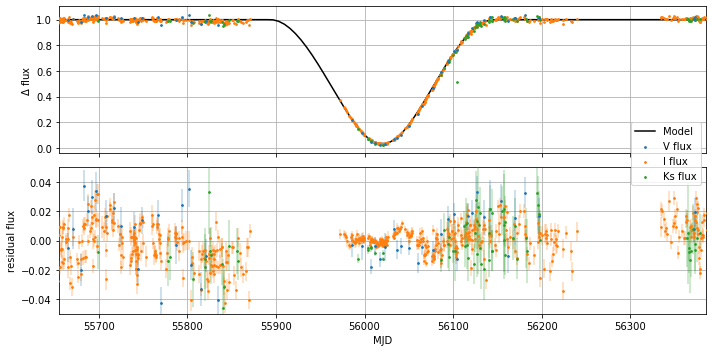

In [29]:
x_model = mapXs(bestX)

t_model = np.linspace(imjdobs.min(), imjdobs.max(), 1000)
b_model = impact_parameter(x_model[0], t_model, x_model[1], x_model[2])
f_model = qld(b_model, x_model[3], 1.05, 0., 1)

b_plot_i = impact_parameter(x_model[0], imjdobs, x_model[1], x_model[2])
f_plot_i = qld(b_plot_i, x_model[3], 1.05, 0., 1)

b_plot_v = impact_parameter(x_model[0], vmjdobs, x_model[1], x_model[2])
f_plot_v = qld(b_plot_v, x_model[3], 1.05, 0., 1)

b_plot_k = impact_parameter(x_model[0], kmjdobs, x_model[1], x_model[2])
f_plot_k = qld(b_plot_k, x_model[3], 1.05, 0., 1)


fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(211)
plt.plot(t_model, f_model, label='Model', c='k')
plt.scatter(vmjdobs,vflux,s=3,label='V flux',zorder=102)
plt.scatter(imjdobs,iflux,s=3,label='I flux',zorder=100)
plt.scatter(kmjdobs,kflux,s=3,label='Ks flux',zorder=101)
plt.grid()
#plt.legend(bbox_to_anchor=(0.9, -0.5))
plt.ylabel("$\Delta$ flux")
plt.xlim(t0_est-365,t0_est+365)

ax2 = plt.subplot(212, sharex=ax1)
plt.errorbar(vmjdobs,vflux-f_plot_v,yerr=vflux_error,fmt=',', alpha=0.3, zorder=102)
plt.scatter(vmjdobs,vflux-f_plot_v,s=3,label='V flux', zorder=202)
plt.errorbar(imjdobs,iflux-f_plot_i,yerr=iflux_error,fmt=',', alpha=0.3, zorder=100)
plt.scatter(imjdobs,iflux-f_plot_i,s=3,label='I flux', zorder=200)
plt.errorbar(kmjdobs,kflux-f_plot_k,yerr=kflux_error,fmt=',', alpha=0.3, zorder=101)
plt.scatter(kmjdobs,kflux-f_plot_k,s=3,label='Ks flux', zorder=202)
plt.grid()
#plt.legend()
plt.xlabel("MJD")
plt.ylabel("residual flux")
plt.xlim(t0_est-365,t0_est+365)
plt.ylim(-0.05, 0.05)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.55))

plt.setp(ax1.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()